# Predicting house prices with linear models

In this project, you will work with the Ames house data set which we already encountered in the lectures. Your task is to evaluate the following three linear models in terms of their performance when predicting house prices:

1. Linear regression
2. Ridge regression
3. Lasso

*General hints:*

1. Whenever a computation involves random number generation, initialise the seed to `123` to get reproducible results. Specifically, for `scikit-learn` functions this requires passing `random_state=123` where applicable.

## Data description

The data is stored in [`data/ames_houses.csv`](../data/ames_houses.csv) in the course [GitHub repository](https://github.com/richardfoltyn/python-intro-PGR) and can be downloaded using the link
[https://raw.githubusercontent.com/richardfoltyn/python-intro-PGR/main/data/ames_houses.csv](https://raw.githubusercontent.com/richardfoltyn/python-intro-PGR/main/data/ames_houses.csv).

To load the data, you need to specify the file path depending on your computing environment:

In [1]:
# Use this path to use the CSV file from the data/ directory
file = '../data/ames_houses.csv'

# Use this path if you want to download the file directly from Github
# file = 'https://raw.githubusercontent.com/richardfoltyn/python-intro-PGR/main/data/ames_houses.csv'

You can load the CSV file as a pandas `DataFrame` as follows:

In [2]:
import pandas as pd

df = pd.read_csv(file, sep=',')

# Display columns in the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SalePrice         1460 non-null   float64
 1   LotArea           1460 non-null   float64
 2   Neighborhood      1460 non-null   object 
 3   BuildingType      1386 non-null   object 
 4   OverallQuality    1460 non-null   int64  
 5   OverallCondition  1460 non-null   int64  
 6   YearBuilt         1460 non-null   int64  
 7   CentralAir        1460 non-null   object 
 8   LivingArea        1460 non-null   float64
 9   Bathrooms         1460 non-null   int64  
 10  Bedrooms          1460 non-null   int64  
 11  Fireplaces        1460 non-null   int64  
 12  HasGarage         1460 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 148.4+ KB


The included variables are a simplified subset of the data available at [openml.org](https://www.openml.org/d/42165):

- `SalePrice`: House price in US dollars (float)
- `LotArea`: Size of the lot in m² (float)
- `Neighborhood`: Name of the neighborhood (string)
- `BuildingType`: Type of building (categorical stored as string)
- `OverallQuality`: Rates the overall condition of the house from (1) "very poor" to (10) "excellent" (integer)
- `OverallCondition`: Rates the overall material and finish of the house from (1) "very poor" to (10) "excellent" (integer)
- `YearBuilt`: Original construction date (integer)
- `CentralAir`: Central air conditioning: Yes/No (categorical string)
- `LivingArea`: Above-ground living area in m² (float)
- `Bathrooms`: Number of bathrooms (integer)
- `Bedrooms`: Number of bedrooms (integer)
- `Fireplaces`: Number of fireplaces (integer)
- `HasGarage`: Indicator whether house has a garage (integer)

# Data preprocessing

Apply the following steps to preprocess the data before estimation:

1. Drop all rows which contain any missing values (`NaN`)

    *Hint:* Use [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    to remove rows with missing observations.

2. Recode the string values in column `CentralAir` into numbers such that 
    `'N'` is mapped to 0 and `'Y'` is mapped to 1. Store this numerical variable
    using the column name `HasCentralAir`.

    *Hint:* You can use boolean operators such as `==` to create arrays
    containing `True` and `False`. You can then convert these to integer
    values 0 and 1 using `.astype(int)`:

    ```python
    (df['CentralAir] == 'Y').astype(int)
    ```
3. Recode the values in column `Fireplaces` and create the new variable `HasFireplace`
    so that `HasFireplace = 1` whenever at least one fireplace is present and 
    `HasFireplace = 0` otherwise.
4. Recode the string values in column `BuildingType` and create the new variable
    `IsSingleFamily` which takes on the value 1 whenever a house is a 
    single-family home and 0 otherwise.
5. Convert the variables `SalePrice`, `LivingArea` and `LotArea` to (natural) logs.
    Name the transformed columns `logSalePrice`, `logLivingArea` and `logLotArea`.

#### Solution

1. Drop missing observations:

In [3]:
# Initial number of observations
Nobs = len(df)

# Drop rows with any missing observation
df = df.dropna()

print(f'Number of observations dropped: {Nobs - len(df)}')

Number of observations dropped: 74


2. Recode string variable `CentralAir`:

In [4]:
# Tabulate frequency of string values
df['CentralAir'].value_counts(dropna=False)

Y    1306
N      80
Name: CentralAir, dtype: int64

One way to convert categorical strings to an indicator variable is as follows:

In [5]:


# Convert to indicator variable
df['HasCentralAir'] = (df['CentralAir'] == 'Y').astype(int)

# Cross-tabulate to make sure recoding worked as intended
pd.crosstab(df['HasCentralAir'], df['CentralAir'])


CentralAir,N,Y
HasCentralAir,,
0,80,0
1,0,1306


3. Recode `Fireplaces` to an indicator variable:

In [6]:
# Any positive number of fireplaces is mapped to 1
df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)

# Cross-tabulate to make sure recoding worked as intended
pd.crosstab(df['HasFireplace'], df['Fireplaces'])

Fireplaces,0,1,2,3
HasFireplace,,,,
0,637,0,0,0
1,0,632,112,5


4. Recode `BuildingType` to an indicator for single-family home:

In [7]:
# Tabulate original string values
df['BuildingType'].value_counts(dropna=False)

Single-family    1220
Townhouse         114
Two-family         52
Name: BuildingType, dtype: int64

In [8]:
# Create indicator variable
df['IsSingleFamily'] = (df['BuildingType'] == 'Single-family').astype(int)

# Cross-tabulate to make sure recoding worked as intended
pd.crosstab(df['IsSingleFamily'], df['BuildingType'])

BuildingType,Single-family,Townhouse,Two-family
IsSingleFamily,,,
0,0,114,52
1,1220,0,0


5. Create logged variables

In [9]:
import numpy as np

columns = ['SalePrice', 'LivingArea', 'LotArea']

# Create logged values
for col in columns:
    df[f'log{col}'] = np.log(df[col])
    # Make sure that no NaNs were generated 
    # (otherwise we'd need to drop those rows)
    assert df[f'log{col}'].notna().all()

# Estimation

## Model specification

You are now asked to estimate the following model of house prices
as a function of house characteristics:
$$
\begin{aligned}
\log(SalePrice_i) 
    &= \alpha + f\Bigl(\log(LivingArea_i), ~
        \log(LotArea_i), ~OverallCondition_i, \\
    & \qquad \qquad \qquad  OverallQuality_i,~ 
    Bathrooms_i,~ Bedrooms_i\Bigr) \\
    &+ \gamma_0 YearBuilt_i + 
    \gamma_1 HasCentralAir_i + 
    \gamma_2 HasFireplace_i + 
    \gamma_3 IsSingleFamily_i + 
    \epsilon_i
\end{aligned}
$$
where $i$ indexes observations and $\epsilon$ is an additive error term.
The function $f(\bullet)$ is a *polynomial of degree 3* in its
arguments, i.e., it includes all terms and interactions of the given variables
where the exponents sum to 3 or less:
$$
\begin{aligned}
f(\log(LivingArea_i), \log(LotArea_i), \dots)
    &= \beta_0 \log(LivingArea_i) 
    + \beta_1 \log(LivingArea_i)^2 \\
    &+ \beta_2 \log(LivingArea_i)^3 
    + \beta_3 \log(LotArea_i) \\
    &+ \beta_4 \log(LotArea_i)^2
    + \beta_5 \log(LotArea_i)^3 \\
    &+ \beta_6 \log(LivingArea_i)\log(LotArea_i) \\
    &+ \beta_7 \log(LivingArea_i)^2 \log(LotArea_i) \\
    &+ \beta_8 \log(LivingArea_i) \log(LotArea_i)^2 \\
    &+ \cdots 
\end{aligned}
$$

Create a feature matrix `X` which contains all polynomial interactions as well as the remaining non-interacted variables.

*Hints:* 

- Use the 
[`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
transformation to create the polynomial terms and interactions from the columns
    `logLivingArea`, `logLotArea`, 
    `OverallCondition`, `OverallQuality`, 
    `Bathrooms` and  `Bedrooms`.
- Make sure that the generated polynomial does *not* contain a 
constant ("bias"). You should include the intercept when estimating a model instead.
- You can use [`np.hstack()`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) to concatenate two matrices (the polynomials and the remaining covariates) along the column dimension.
- The complete feature matrix `X` should contain a total of 87 columns (83 polynomial interactions and 4 non-polynomial features).

#### Solution

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Endogenous (target) variable
target = 'logSalePrice'

# Features included as polynomials
features_poly = [
    'logLivingArea', 'logLotArea', 
    'OverallCondition', 'OverallQuality', 
    'Bathrooms', 'Bedrooms'
]

# Other features not included in polynomials
features_other = [
    'YearBuilt',
    'HasCentralAir', 'HasFireplace', 'IsSingleFamily'
]

# Keep only columns that are used to estimate model
columns = [target] + features_poly + features_other
df = df[columns]

# Response variable
y = df[target].to_numpy()

# Create polynomials of degree 3 or less, excluding intercept
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(df[features_poly].to_numpy())
print(f'Number of polynomial features: {X_poly.shape[1]}')

# Remaining features that are not use in polynomial
X_other = df[features_other].to_numpy()
print(f'Number of non-polynomial features: {X_other.shape[1]}')

# Create final feature matrix
X = np.hstack((X_poly, X_other))

# Print number of observations in final sample
print(f'Number of observations: {X.shape[0]}')

Number of polynomial features: 83
Number of non-polynomial features: 4
Number of observations: 1386


## Train-test sample split

Split the data into a training and a test subset such that the training
sample contains 70% of observations.

*Hint:* 

- Use the function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the sample.
    Pass the argument `random_state=123` to get reproducible results.
- Make sure to define the training and test samples only *once* so that they are identical for all estimators used below. 

#### Solution

Define global variables applicable to all estimators:

In [11]:
# Global configuration

RANDOM_STATE = 123      # Random state (for train/test split and cross-validation)

The helper function 
[`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
can be used to randomly assign 70% of observations to the training sub-set.

In [12]:
from sklearn.model_selection import train_test_split

# Fraction assigned to test sub-set
test_size = 0.3

# Split feature matrix and target variable
X_train, X_test, y_train, y_test  = train_test_split(
    X, y, 
    test_size=test_size,
    random_state=RANDOM_STATE
)

print(f'Number of observation in training sample: {X_train.shape[0]}')
print(f'Number of observation in test sample: {X_test.shape[0]}')

Number of observation in training sample: 970
Number of observation in test sample: 416


## Linear regression

Perform the following tasks:

1. Do you need to standardise features before estimating a linear regression model? Does the linear regression model have any hyperparameters?
2. Estimate the above model specification using a linear regression model on the training sub-set. 
3. Compute and report the mean squared error (MSE) on the test sample.

*Hints:*

- Use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class to estimate the model.
- The mean squared error can be computed with [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

#### Solution

A plain linear regression model can be estimated using
[`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). 

- No standardisation is needed for plain linear regression models.
- The linear regression model in general does not have any hyperparameters. We could view the polynomial degree used to create the feature matrix as a hyperparameter, but we don't tune this parameter in this exercise.

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)

y_test_hat = lr.predict(X_test)

To compute the MSE on the test sample, we use the helper function
[`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [14]:
from sklearn.metrics import mean_squared_error

# Compute MSE on test sample
mse_lr = mean_squared_error(y_test, y_test_hat)

print(f'MSE for linear regression (test sample): {mse_lr:,.5g}')

MSE for linear regression (test sample): 0.03264


## Ridge regression

Perform the following tasks:

1. Does Ridge regression require feature standardisation? If so, don't forget to apply it before fitting the model.
2. Use [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
    to determine the best regularisation strength $\alpha$ on the training sub-sample.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.
3. Plot the MSE (averaged over folds on the training sub-sample) against the regularisation strength $\alpha$ on the $x$-axis (use a log scale for the $x$-axis).
4. Compute and report the MSE on the test sample.

*Hints:* 

- When running `RidgeCV`, use a grid of 500 $\alpha$'s which are spaced uniformly in logs:
    ```python
    alphas = np.logspace(np.log10(1.0e-6), np.log10(100), 500)
    ```
- Recall that the (negative!) best MSE is stored in the attribute `best_score_` after cross-validation is complete.

#### Solution

The Ridge regression model can be sensitive to scaling so we standardise the features before fitting the model.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

transform = make_pipeline(
    StandardScaler()
)

X_train_trans = transform.fit_transform(X_train)

alphas = np.logspace(np.log10(1.0e-6), np.log10(100), 500)

rcv = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train_trans, y_train)

In [16]:
# Recover best alpha that minimizes MSE
alpha_best = rcv.alpha_

# Best MSE is stored as negative score!
MSE_best = - rcv.best_score_

print(f'Best alpha: {alpha_best:.3g} (MSE: {MSE_best:,.5g})')

Best alpha: 0.0229 (MSE: 0.025092)


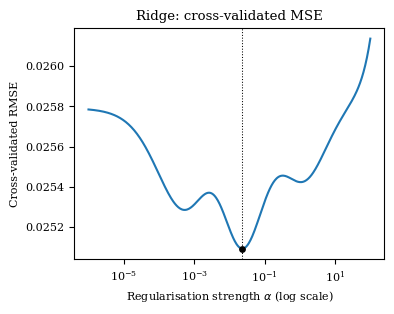

In [17]:
import matplotlib.pyplot as plt

# Compute average MSE for each alpha value across all folds
rmse_mean = np.mean(rcv.cv_values_, axis=0)

# Index of MSE-minimising alpha
imin = np.argmin(rmse_mean)

# Plot MSE against alphas, highlight minimum MSE
plt.plot(alphas, rmse_mean)
plt.xlabel(r'Regularisation strength $\alpha$ (log scale)')
plt.ylabel('Cross-validated RMSE')
plt.scatter(alphas[imin], rmse_mean[imin], s=15, c='black', zorder=100)
plt.axvline(alphas[imin], ls=':', lw=0.75, c='black')
plt.title('Ridge: cross-validated MSE')
plt.xscale('log')

In [18]:
from sklearn.linear_model import Ridge

pipe_ridge = make_pipeline(
    StandardScaler(), 
    Ridge(alpha=alpha_best, fit_intercept=True)
)

pipe_ridge.fit(X_train, y_train)

y_test_hat = pipe_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_test_hat)

print(f'MSE for Ridge regression (test sample): {mse_ridge:,.5g}')

MSE for Ridge regression (test sample): 0.030267


## Lasso

Perform the following tasks:

1. Does Lasso require feature standardisation? If so, don't forget to apply it before fitting the model.
2. Use [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
    to determine the best regularisation strength $\alpha$ on the training sub-sample
    using cross-validation with 5 folds.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.
3. Plot the MSE (averaged over folds on the training sub-sample) against the regularisation strength $\alpha$ on the $x$-axis (use a log scale for the $x$-axis).
4. Compute and report the MSE on the test sample for the model using the optimal $\alpha$.
5. Report the number of non-zero coefficients for the model using the optimal $\alpha$.

*Hints:* 

- Getting Lasso to converge may require some experimentation. The following settings should help: increase the max. number of iterations to `max_iter=1000000` and use `selection='random'`. Set `random_state=123` to get reproducible results:

    ```python
    LassoCV(..., max_iter=1000000, selection='random', random_state=123)
    ```
- Use `eps=1.0e-4` as an argument to `LassoCV` to specify the ratio of the smallest to the largest $\alpha$.
- After cross-validation is complete, the MSE for each value of $\alpha$ and each fold are stored in the attribute `mse_path_` which is an array with shape `(N_ALPHA, N_FOLDS)`.

#### Solution

In [19]:
# Global configuration

NFOLDS = 5              # Number of folds for cross-validation (for Lasso)
MAXITER = 1000000       # Max. iterations (for Lasso)
SELECTION = 'random'    # Selection of component to update (for Lasso)

Just like Ridge regression, Lasso can be sensitive to scaling and we thus need to standardise the features before fitting the model.
`LassoCV` does all the work for us, so we only need to specify the grid of candidate $\alpha$ values. Using `eps=1.0e-4` instead of the default value increases the range of candidate $\alpha$.

In [20]:
from sklearn.linear_model import LassoCV

# Define and fit Lasso CV
lcv = LassoCV(eps=1.0e-4, 
    n_alphas=200,
    max_iter=MAXITER, 
    cv=NFOLDS, 
    random_state=RANDOM_STATE, 
    selection=SELECTION,
).fit(X_train_trans, y_train)


We can recover the optional $\alpha$ and the mean MSE from the fitted object as follows:

In [21]:
# Recover best alpha that minimizes MSE
alpha_best = lcv.alpha_

# MSE for each alpha, averaged over folds
mse_mean = np.mean(lcv.mse_path_, axis=1)

# Index of min. MSE
imin = np.argmin(mse_mean)

mse_best = mse_mean[imin]

print(f'Best alpha: {alpha_best:.4g} (MSE: {mse_best:.5g})')

Best alpha: 7.5e-05 (MSE: 0.025038)


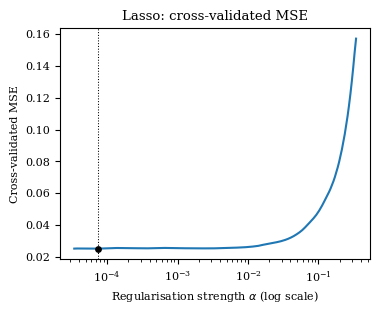

In [22]:
import matplotlib.pyplot as plt

# Plot MSE against alphas, highlight minimum MSE
plt.plot(lcv.alphas_, mse_mean)
plt.xlabel(r'Regularisation strength $\alpha$ (log scale)')
plt.ylabel('Cross-validated MSE')
plt.scatter(lcv.alphas_[imin], mse_mean[imin], s=15, c='black', zorder=100)
plt.axvline(lcv.alphas_[imin], ls=':', lw=0.75, c='black')
plt.title('Lasso: cross-validated MSE')
plt.xscale('log')

Once the optional $\alpha$ is identified, we re-estimate the Lasso and compute the predicted values on the test sample as well as the MSE.

In [23]:
from sklearn.linear_model import Lasso

pipe_lasso = make_pipeline(
    StandardScaler(), 
    Lasso(alpha=alpha_best, 
        fit_intercept=True, 
        max_iter=MAXITER,
        selection=SELECTION,
        random_state=RANDOM_STATE
    )
)

pipe_lasso.fit(X_train, y_train)

y_test_hat = pipe_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_test_hat)

print(f'MSE for Lasso regression (test sample): {mse_lasso:,.5g}')

MSE for Lasso regression (test sample): 0.024137


The number of non-zero coefficients can be recovered as follows:

In [24]:
Ncoefs = len(pipe_lasso.named_steps.lasso.coef_)
Ncoefs_nonz = np.sum(np.abs(pipe_lasso.named_steps.lasso.coef_) > 1.0e-8)
print(f'Number of non-zero coefficients: {Ncoefs_nonz} (out of {Ncoefs})')

Number of non-zero coefficients: 45 (out of 87)


## Compare estimation results

Create a table which contains the MSE computed on the test sample for all three models (using their optimal hyperparameters). Which model yields the lowest MSE?

#### Solution

The following code combines the MSEs computed in the previous sections and tabulates them by estimator. As can be seen, the Lasso performs best among the three estimators, yielding the smallest MSE on the test sub-sample.

In [25]:
# Create Table with results

# Compute all previously estimated MSE
MSE_all = [mse_lr, mse_ridge, mse_lasso]

# Model labels
labels = ['Linear Reg', 'Ridge', 'Lasso']

# Create DataFrame, allows for pretty printing of results
results = pd.DataFrame({'MSE': MSE_all}, index=pd.Index(labels, name='Estimator'))

results

,MSE
Estimator,
Linear Reg,0.032640
Ridge,0.030267
Lasso,0.024137
